# Excercise: Collecting unstructured data - identifying customer segments

URL: http://archive.ics.uci.edu/ml/datasets/Wholesale+customers

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories. 

### Description of categories
- FRESH: annual spending (m.u.) on fresh products (Continuous)
- MILK: annual spending (m.u.) on milk products (Continuous)
- GROCERY: annual spending (m.u.) on grocery products (Continuous)
- FROZEN: annual spending (m.u.)on frozen products (Continuous)
- DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
- DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous)
    - "A store selling cold cuts, cheeses, and a variety of salads, as well as a selection of unusual or foreign prepared foods."

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for dataframes
%matplotlib inline

In [3]:
data = pd.read_csv('Wholesale customers data.csv')
data.head(8)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566


Our data set has 440 samples in it. It has 6 dimensions (Region ~ Delicassen) - called features here, and two distinct channel (Hotel/Restaurant/Cafe = 1 vs. Retail = 2) that each row is classified into.

While we can visualize 2 or even 3 dimensions of data pretty easily, visualizing 6D data isn't something our brains can do. So let's distill this down to 2 dimensions, and see how well it works:

In [4]:
# Separate Channel column and other columns since we will be predicting channel
X = data.loc[: , "Region":"Delicassen"]
channel = pd.DataFrame(data["Channel"])

In [5]:
from sklearn.decomposition import PCA

# Reduce dimension into 2D
pca = PCA(n_components=2, whiten=True).fit(X)
X_pca = pca.transform(X)

X_pca[0]

array([ 0.05066239,  0.13161505])

Let's see how much information we've managed to preserve:

In [6]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[ 0.45961362  0.40517227]
0.8647858835


Although we have thrown away four of our six dimensions, PCA has chosen the remaining two dimensions and captured 46% of the variance in our data in a first dimension and 40% in the second dimension. Altogether we've lost 14% of the variance in our data by projecting it down to two dimensions.

In [7]:
# merge channels and two dimension back into a single Data Frame

df = pd.DataFrame(X_pca, columns=['x','y']) 
channel[['x','y']] = df
channel.head()

,Channel,x,y
0,2,0.050662,0.131615
1,2,-0.345023,0.335567
2,2,-0.377383,0.214065
3,1,0.077187,-0.521291
4,2,0.830679,-0.179280


Scatter plot the data

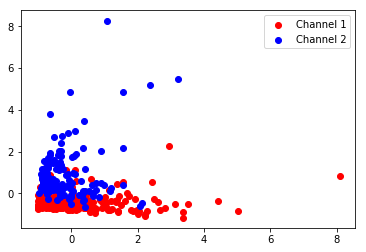

In [8]:
%matplotlib inline
from pylab import *

channel_one = channel[channel["Channel"] == 1]
channel_two = channel[channel["Channel"] == 2]
plt.scatter(channel_one["x"], channel_one["y"], color = 'red', label = "Channel 1")
plt.scatter(channel_two["x"], channel_two["y"], color = 'blue', label ="Channel 2")
plt.legend()

Use Support Vector Machine (SVM), a frontier which best segregates the two classes.

In [9]:
from sklearn import svm

X = np.array(channel[['x','y']])
y = np.array(channel["Channel"])

# SVM regularization parameter
C = 1.0

# Linear SVC (linear kernel)
lin_svc = svm.SVC(kernel='linear', C=C).fit(X,y)

# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)

# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)

### Plot SVC

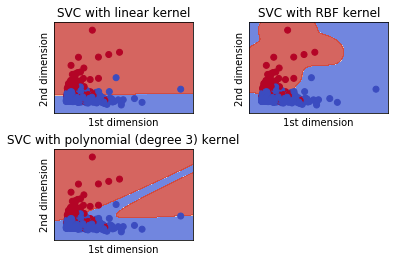

In [10]:
# create a mesh to plot in

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('1st dimension')
    plt.ylabel('2nd dimension')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

### Visualizing linear line that separates two clusters

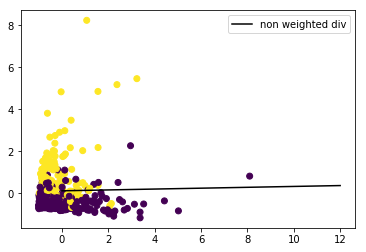

In [11]:
# Creating dividing line
w = lin_svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(0,12)
yy = a*xx - lin_svc.intercept_[0] / w[1]
h0 = plt.plot(xx,yy,'k-',label = 'non weighted div')

plt.scatter(X[:,0], X[:,1], c=y)
plt.legend()
plt.show()

------------------------------------------------------

# Making Predictions

**Index 0**

In [12]:
lin_svc.predict([[0.050662,0.131615]])

array([2], dtype=int64)

Class predicted as 2

**Index 3**

In [14]:
lin_svc.predict([[0.077187,-0.521291]])

array([1], dtype=int64)

Class predicted as 1